# Streaming

Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

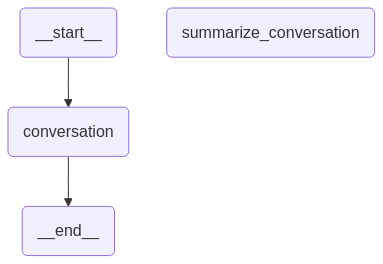

In [1]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

model = ChatOpenAI(model='gpt-4.1-nano', temperature=0)

class State(MessagesState):
    summary: str

def call_mode(state:State, config: RunnableConfig):

    summary = state.get("summary","")

    if summary:

        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:

        messages = state['messages']

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state:State):

    summary = state.get("summary", "")

    if summary:

        summary_message = (
            f"This is summary of the conversation to date: {summary} \n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_conitinue(state:State):

    messages = state['messages']

    if len(messages) >6:
        return "summarize_conversation"

    return END

workflow = StateGraph(State)
workflow.add_node("conversation", call_mode)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_conitinue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming full state



[stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [2]:
config = {"configurable": {'thread_id':"1"}}

for chunk in graph.stream({'messages': [HumanMessage(content="hi! I'm Raahul")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello, Raahul! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'id': 'chatcmpl-BXTshB5HKm72eKTyHTjAbPwJPErCJ', 'finish_reason': 'stop', 'logprobs': None}, id='run-793bb093-5ad1-4121-aaee-26c6be6f8faf-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [3]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Raahul")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi, Raahul! Nice to meet you. How can I help you today?


In [4]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Leo Das")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*30)

================================ Human Message =================================

hi! I'm Leo Das
------------------------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Leo Das
================================== Ai Message ==================================

Hello, Leo! Nice to meet you. How can I assist you today?
------------------------------------------------------------------------------------------


## Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [5]:
config = {"configurable":{"thread_id":"3"}}

input_message = HumanMessage(content=f"Tell me about RCB")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {{event['name]}}")

Node: . Type: on_chain_start. Name: {event['name]}
Node: conversation. Type: on_chain_start. Name: {event['name]}
Node: conversation. Type: on_chat_model_start. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {event['name]}
Node: conversation. Type: on_chat_model_stream. Name: {even

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [6]:
config = {"configurable":{"thread_id":"4"}}
node_to_stream = 'conversation'

input_message = HumanMessage(content=f"Tell me about RCB")
async for event in graph.astream_events({"messages":[input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data'])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content='Certainly', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content='!', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content=' R', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content='CB', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content=' or', additional_kwargs={}, response_metadata={}, id='run-2aa76711-f591-4c5d-a2e6-2e73f4673e3e')}
{'chunk': AIMessageChunk(content=' Royal', additional_kwargs={}, response_metad

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [7]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about RCB")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Certainly|!| R|CB|,| or| Royal| Chall|engers| Bangalore|,| is| a| professional| Twenty|20| cricket| team| based| in| Bangalore|,| Karnataka|,| India|.| They| compete| in| the| Indian| Premier| League| (|IPL|),| which| is| one| of| the| most| popular| and| competitive| T|20| cricket| leagues| in| the| world|.

|**|Key| Facts| about| R|CB|:|**

|-| **|Founded|:**| |200|8|,| the| inaugural| season| of| the| IPL|.
|-| **|Ownership|:**| The| team| is| owned| by| United| Spirits|,| a| subsidiary| of| Di|age|o|.
|-| **|Team| Colors|:**| Red| and| black|.
|-| **|Home| Ground|:**| M|.| Ch|inn|as|w|amy| Stadium| in| Bangalore|,| which| has| a| seating| capacity| of| around| |40|,|000| spectators|.
|-| **|Team| Nick|name|:**| The| Chall|engers|.

|**|Performance| Highlights|:|**

|-| R|CB| is| known| for| its| explosive| batting| lineup| and| has| featured| some| of| the| biggest| names| in| cricket|.
|-| Despite| having| a| strong| squad| over| the| years|,| R|CB| has| yet| to| win| an| IPL| ti

In [8]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistanst = await client.assistants.search()

In [9]:
thread = await client.threads.create()

input_message = HumanMessage(content="Multiply 2 and 5")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id='agent',
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1f031991-847a-6728-af53-70be359c8024', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 5', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '69320573-0860-4b94-8f9c-0af39c3ebf97', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 5', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '69320573-0860-4b94-8f9c-0af39c3ebf97', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_t4MeE7CCsT4FfIGNsmoEsfjx', 'function': {'arguments': '{"a":2,"b":5}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

The streamed objects have: 

* `event`: Type
* `data`: State

In [10]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 5")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages":[input_message]}, stream_mode="values"):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*50)

content='Multiply 2 and 5' additional_kwargs={} response_metadata={} id='42d9c538-5ac4-4049-ae41-41f0b2cc3950'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_gwHTlDZx6sZREPZg4JWt7cmt', 'function': {'arguments': '{"a":2,"b":5}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_55d88aaf2f', 'id': 'chatcmpl-BXTt3RH5ARgpt3ElgYohTkH1J6mSx', 'finish_reason': 'tool_calls', 'logprobs': None} id='

In [11]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [12]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.data)

{'run_id': '1f031991-c25d-6891-beaf-4b297ab835f8', 'attempt': 1}
{'run-e8e90b7a-4f00-4a56-856b-984a6f7d39e7': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.3.34', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'user-agent': 'langgraph-sdk-py/0.1.63', 'langgraph_auth_user_id': '', 'run_id': '1f031991-c25d-6891-beaf-4b297ab835f8', 'thread_id': '39c360bd-8c26-4e1b-9a39-2459b0b8a3bb', 'user_id': '', 'langgraph_step': 1, 'langgraph_node': 'assistant', 'langgraph_triggers': ['branch:to:assistant'], 'langgraph_path': ['__pregel_pull', 'assistant'], 'langgraph_checkpoint_ns': 'assistant:a8034d6c-5a7f-baf3-839b-c8d48902bc1d', 'checkpoint_ns': 'assistant:a8034d6c-5a7f-baf3-839b-c8d48902bc1d', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': None}}}
[{'content': '', 'additional_kw

In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1f031991-da08-662f-a2fe-a68a1b01b889
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_8yzEGWif48SGxemCDrl8acVZ, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

# Breakpoints

Goals

`Human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

[Breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

In [14]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b:int)-> int:
    """ 
    Mulitply a and b
    
    Args:
        a: first int
        b: second int    
    """

    return a * b

def add(a:int, b:int)-> int:
    """
    Add a and b

    Agrs:
        a: first int
        b: second int
    """

    return a + b

def div(a: int, b:int)-> float:
    """
    Divide a by b

    Args:
        a: first int
        b: second int
    """

    return a/b

tools = [multiply, add, div]
llm = ChatOpenAI(model='gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_mrg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_mrg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)


In [18]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_GFrcCO9zERxCigb3E9y4oJDk)
 Call ID: call_GFrcCO9zERxCigb3E9y4oJDk
  Args:
    a: 2
    b: 3


In [19]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [20]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_GFrcCO9zERxCigb3E9y4oJDk)
 Call ID: call_GFrcCO9zERxCigb3E9y4oJDk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [21]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YbSOMYlONBL4SZeGxfOR3VYo)
 Call ID: call_YbSOMYlONBL4SZeGxfOR3VYo
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YbSOMYlONBL4SZeGxfOR3VYo)
 Call ID: call_YbSOMYlONBL4SZeGxfOR3VYo
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


# Edit Human State Feedback 

In [44]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b:int)-> int:
    """ Multiply a and b 
    Args:
        a: first int
        b: second int 
    """
    return a * b

def add(a:int, b:int)-> int:
    """ Add a and b
    Args:
        a: first int 
        b: second int 
    """
    return a + b 

def div(a: int, b: int) -> float:
    """ Divide a by b
    Args:
        a: first int
        b: secodn int 
    """
    return a/b

tools = [add, multiply, div]
llm = ChatOpenAI(model='gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

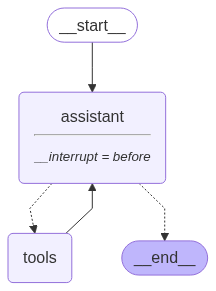

In [45]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage

sys_mrg = SystemMessage(content="Ypu are a helpful assistant tasked with performing arithmetic on a set of inputs ")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_mrg] + state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
initial_input = {"messages": "multiply 2 and 3"}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


In [47]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='afc6419b-195b-4e39-bbf2-5d266b7a311c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031a99-443d-67b0-8000-fc7587b77224'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-15T16:28:05.519352+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f031a99-4438-67d7-bfff-25734d46a8cd'}}, tasks=(PregelTask(id='e56770e0-cb5d-4d6c-33aa-1c97b866c2e2', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [48]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually add 2 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f031a99-7b3b-6c7f-8001-70c8ed0dfff6'}}

In [49]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================ Human Message =================================

No, actually add 2 and 3!


In [50]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually add 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  add (call_LNZxX1OSuuohiQuOCwclZOID)
 Call ID: call_LNZxX1OSuuohiQuOCwclZOID
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5


In [51]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

The sum of 2 and 3 is 5.


## Awaiting user input

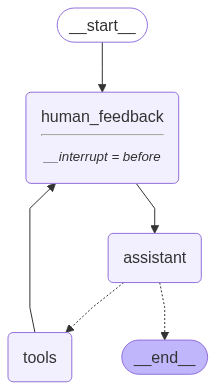

In [52]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Add 10 and 9
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hSPSltujcYyDA29Kr1wNI5sI)
 Call ID: call_hSPSltujcYyDA29Kr1wNI5sI
  Args:
    a: 2
    b: 3
  add (call_1upjFwwktmqXMn0N3ZxKBj29)
 Call ID: call_1upjFwwktmqXMn0N3ZxKBj29
  Args:
    a: 10
    b: 9
================================= Tool Message =================================
Name: add

19


In [54]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

The product of 2 and 3 is 6.  
The sum of 10 and 9 is 19.
